Epoch [1/200], Loss: 3.3677
Epoch [10/200], Loss: 0.2709
Epoch [20/200], Loss: 0.2040
Epoch [30/200], Loss: 0.1716
Epoch [40/200], Loss: 0.1539
Epoch [50/200], Loss: 0.1523
Epoch [60/200], Loss: 0.1467
Epoch [70/200], Loss: 0.1284
Epoch [80/200], Loss: 0.1246
Epoch [90/200], Loss: 0.1095
Epoch [100/200], Loss: 0.1009
Epoch [110/200], Loss: 0.0938
Epoch [120/200], Loss: 0.0958
Epoch [130/200], Loss: 0.0866
Epoch [140/200], Loss: 0.0835
Epoch [150/200], Loss: 0.0843
Epoch [160/200], Loss: 0.0778
Epoch [170/200], Loss: 0.0804
Early stopping at epoch 172


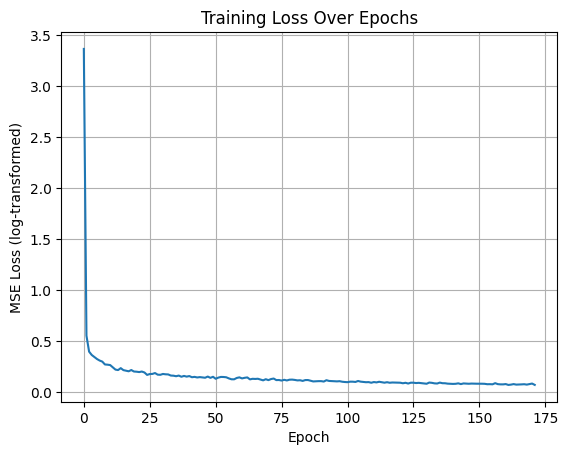


Evaluation Metrics on Test Data:
MAE: 1.63 kg CO2
RMSE: 2.12 kg CO2
% Error: 45.38%


['preprocessor.pkl']

In [1]:
# Carbon Emission Prediction Model with Log-Transformed Target and Error-Free Handling

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import joblib
import os

# Load dataset
df = pd.read_csv("/kaggle/input/carbon-emmision/logistics_emission_data.csv")

# Drop rows with missing or invalid target values
df = df[df['carbon_emission_kg'].notna()]
df = df[df['carbon_emission_kg'] > 0]  # Remove zero or negative targets

# Features and target
categorical_features = ['traffic_level']
numeric_features = df.drop(['carbon_emission_kg'] + categorical_features, axis=1).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

X = df.drop('carbon_emission_kg', axis=1)
y = np.log1p(df['carbon_emission_kg'].values)  # log(1 + x) for stability

X_scaled = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PyTorch Dataset
class EmissionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmissionDataset(X_train, y_train)
test_dataset = EmissionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define the MLP Model
class EmissionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model
model = EmissionModel(input_dim=X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop with early stopping
epochs = 200
train_losses = []
best_loss = float('inf')
patience, trigger_times = 10, 0
best_model_path = 'best_emission_model.pth'

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Stopping training.")
            break

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # Early stopping
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}")

# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log-transformed)")
plt.grid(True)
plt.show()

# Load best model if it was saved
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
else:
    print("Warning: Best model not found. Using current model.")

# Evaluation
model.eval()
y_pred_log, y_true_log = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        y_pred_log.extend(outputs.squeeze().tolist())
        y_true_log.extend(y_batch.squeeze().tolist())

# Inverse transform to original target scale
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_true_log)

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
percent_error = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100

print(f"\nEvaluation Metrics on Test Data:")
print(f"MAE: {mae:.2f} kg CO2")
print(f"RMSE: {rmse:.2f} kg CO2")
print(f"% Error: {percent_error:.2f}%")

# Save final model and preprocessor
torch.save(model.state_dict(), 'emission_model_final.pth')
joblib.dump(preprocessor, 'preprocessor.pkl')
